In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [148]:
file_path = "ibm.csv"
file_cleaned_path = "cleaned_ibm_data.csv"
data = pd.read_csv(file_path)

print(data.head())

                        Date      Open      High       Low     Close  Volume  \
0  1962-01-02 00:00:00-05:00  1.530517  1.530517  1.513320  1.513320  407940   
1  1962-01-03 00:00:00-05:00  1.513320  1.526548  1.513320  1.526548  305955   
2  1962-01-04 00:00:00-05:00  1.526548  1.526548  1.510674  1.511336  274575   
3  1962-01-05 00:00:00-05:00  1.509353  1.509353  1.478927  1.481573  384405   
4  1962-01-08 00:00:00-05:00  1.480251  1.480251  1.441889  1.453794  572685   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


In [149]:
data_filtered = data[["Date", "Open", "High", "Low", "Volume", "Close"]].sort_values(by="Date")
data_cleaned = data_filtered.dropna()
print(data_filtered.head())

                        Date      Open      High       Low  Volume     Close
0  1962-01-02 00:00:00-05:00  1.530517  1.530517  1.513320  407940  1.513320
1  1962-01-03 00:00:00-05:00  1.513320  1.526548  1.513320  305955  1.526548
2  1962-01-04 00:00:00-05:00  1.526548  1.526548  1.510674  274575  1.511336
3  1962-01-05 00:00:00-05:00  1.509353  1.509353  1.478927  384405  1.481573
4  1962-01-08 00:00:00-05:00  1.480251  1.480251  1.441889  572685  1.453794


In [150]:
data_cleaned.to_csv(file_cleaned_path, index=False)

In [151]:
data = pd.read_csv(file_cleaned_path)
data.head()

,Date,Open,High,Low,Volume,Close
0,1962-01-02 00:00:00-05:00,1.530517,1.530517,1.513320,407940,1.513320
1,1962-01-03 00:00:00-05:00,1.513320,1.526548,1.513320,305955,1.526548
2,1962-01-04 00:00:00-05:00,1.526548,1.526548,1.510674,274575,1.511336
3,1962-01-05 00:00:00-05:00,1.509353,1.509353,1.478927,384405,1.481573
4,1962-01-08 00:00:00-05:00,1.480251,1.480251,1.441889,572685,1.453794


In [152]:
data["Target"] = data["Close"].shift(-1)
data.head()

,Date,Open,High,Low,Volume,Close,Target
0,1962-01-02 00:00:00-05:00,1.530517,1.530517,1.513320,407940,1.513320,1.526548
1,1962-01-03 00:00:00-05:00,1.513320,1.526548,1.513320,305955,1.526548,1.511336
2,1962-01-04 00:00:00-05:00,1.526548,1.526548,1.510674,274575,1.511336,1.481573
3,1962-01-05 00:00:00-05:00,1.509353,1.509353,1.478927,384405,1.481573,1.453794
4,1962-01-08 00:00:00-05:00,1.480251,1.480251,1.441889,572685,1.453794,1.470989


In [153]:
final_data_row = data.tail(1)
data.drop(data.tail(1).index, inplace=True)
data.dropna(inplace=True)
final_data_row

,Date,Open,High,Low,Volume,Close,Target
15796,2024-10-03 00:00:00-04:00,219.5,222.559998,219.335007,1996604,221.490005,NaN


In [154]:
data.iloc[:, 1:].corr()['Close']

,Close
Open,0.999891
High,0.999945
Low,0.999945
Volume,0.137023
Close,1.000000
Target,0.999812


In [155]:
last = data.tail(1)
data.drop(data.tail(1).index, inplace=True)
data.dropna(inplace=True)

In [156]:
# Features scaling
model_features = data.drop("Target", axis=1).drop("Date", axis=1)
model_target = data["Target"]

model_feature_scaler = MinMaxScaler()
model_feature_scaler.fit(model_features)
model_scaled_features = pd.DataFrame(model_feature_scaler.transform(model_features), columns=model_features.columns.tolist())

model_target_scaler = MinMaxScaler()
model_target_scaler.fit(model_target.values.reshape(-1,1))
model_scaled_target = pd.DataFrame(model_target_scaler.transform(model_target.values.reshape(-1,1)), columns=["Target"])

In [157]:
def create_dataset(X_data, y_data, t_steps):
    X, y = [], []
    for i in range(len(X_data) - t_steps):
        v = X_data.iloc[i:(i + t_steps)].values
        X.append(v)
        y.append(y_data.iloc[i + t_steps])
    return np.array(X), np.array(y)

In [158]:
t_steps = 60
X, y = create_dataset(model_scaled_features, model_scaled_target, t_steps)
X.shape, y.shape

((15735, 60, 5), (15735, 1))

In [159]:
train_size = int(0.80 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12588, 60, 5), (3147, 60, 5), (12588, 1), (3147, 1))

In [72]:
# def create_lstm_model(input_shape):
#   model = Sequential([
#       LSTM(units=64,
#            return_sequences=True,
#            input_shape=(input_shape[1], input_shape[2]),
#            activation='relu'),
#       BatchNormalization(),
#       LSTM(units=32,
#            return_sequences=True,
#            activation='relu'),
#       BatchNormalization(),
#       LSTM(units=16,
#            return_sequences=False,
#            activation='relu'),
#       BatchNormalization(),
#       Dense(units=1),
#       ])
#   model.compile(optimizer=Adam(learning_rate=0.001),
#                   loss='mse',
#                   metrics=['mae', 'r2_score'])
#   return model


In [160]:
def create_lstm_model(input_shape, lr=0.005):
  model = Sequential()
  model.add(LSTM(units=64, activation="tanh", return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(BatchNormalization())
  model.add(LSTM(units=32, activation="tanh", return_sequences=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(units=1))
  model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error', metrics=["mean_absolute_error", "r2_score"])
  return model



In [161]:
lstm_model = create_lstm_model(X_train.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [162]:
# Callbacks
callbacks = [
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        mode='min',
        verbose=1
    ),

    # Model checkpoint
    ModelCheckpoint(
        'best_lstm_model.keras',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    ),

    # Reduce learning rate model finds a plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=7,
        min_lr=1e-4,
        mode='min',
        verbose=1
    )
]

In [163]:
lstm_history = lstm_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=32,
    shuffle=False,
    # callbacks=callbacks,
    verbose=1)

Epoch 1/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.1443 - mean_absolute_error: 0.1003 - r2_score: -155807.7500 - val_loss: 1.6217 - val_mean_absolute_error: 0.5389 - val_r2_score: -171.4503
Epoch 2/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0199 - mean_absolute_error: 0.0689 - r2_score: -24719.9707 - val_loss: 30.0595 - val_mean_absolute_error: 1.6738 - val_r2_score: -3195.4578
Epoch 3/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0199 - mean_absolute_error: 0.0686 - r2_score: -24384.5898 - val_loss: 0.0213 - val_mean_absolute_error: 0.1259 - val_r2_score: -1.2683
Epoch 4/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0201 - mean_absolute_error: 0.0687 - r2_score: -24893.4316 - val_loss: 0.0783 - val_mean_absolute_error: 0.2794 - val_r2_score: -7.3314
Epoch 5/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0192 - mean_absolute_error: 0.0658 - r2_score: -24223.0254 - val_loss: 0.2127 - val_mean_absolute_error: 0.4607 - val_r2_score: -21.6

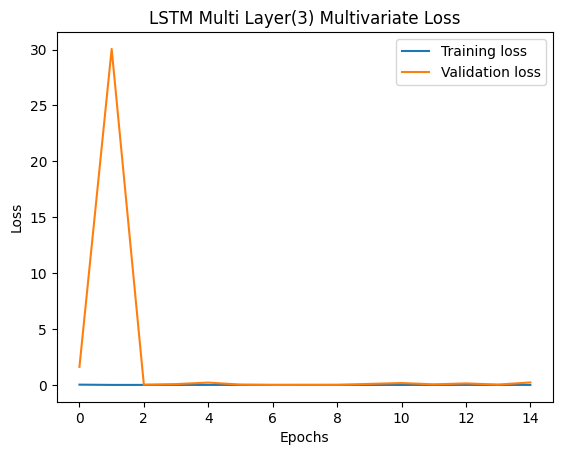

In [164]:
plt.plot(lstm_history.history['loss'], label='Training loss')
plt.plot(lstm_history.history['val_loss'], label='Validation loss')
plt.title("LSTM Multi Layer(3) Multivariate Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [165]:
y_pred_lstm = lstm_model.predict(X_test)

99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [135]:
y_pred_lstm = model_target_scaler.inverse_transform(y_pred_lstm)

In [136]:
y_test_results = model_target_scaler.inverse_transform(y_test)
y_test_results

array([[123.27696991],
       [123.50193024],
       [123.9872818 ],
       ...,
       [220.83999634],
       [221.08000183],
       [219.3500061 ]])

In [166]:
# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred_lstm)
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mse)
# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred_lstm)
# R2 score
r2 = r2_score(y_test, y_pred_lstm)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)

MSE:  0.22545044898817607
RMSE:  0.4748162265426236
MAE:  0.474614062477505


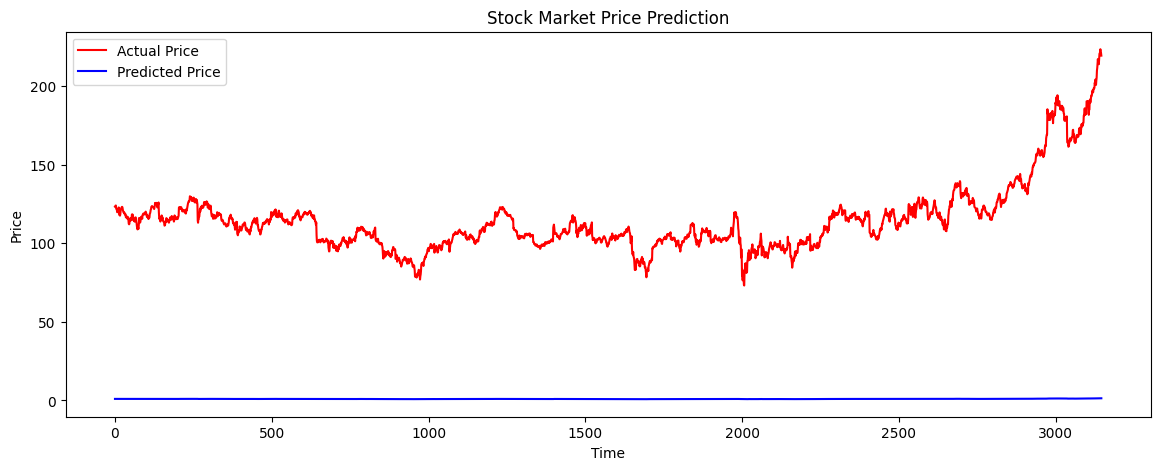

In [167]:
plt.figure(figsize=(14,5))
plt.plot(y_test_results, color='red', label='Actual Price')
plt.plot(y_pred_lstm, color='blue', label='Predicted Price')
plt.title('Stock Market Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [140]:
final_data_row

array([[[0.98424773, 0.99287952, 0.99081911, 0.02748661, 0.99128566]]])

In [144]:
# Caclulate for last "timesteps" days
final_data_row = final_data_row.drop("Target", axis=1).drop("Date", axis=1)
final_data_row = model_feature_scaler.transform(final_data_row)
final_data_row = final_data_row.reshape(1, 1, final_data_row.shape[1])

# Next day prediction
next_day_price = lstm_model.predict(final_data_row)
next_day_price = model_target_scaler.inverse_transform(next_day_price)
print("Next day price: ", next_day_price[0][0])

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [26]:
lstm_model.save("lstm_model.keras")